# Fun part: How well do the different models perform on totally new data
## Take this with a grain of salt: our model has never been trained for signs in real life szenarios, so they will of course not perform well in this setting

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import matplotlib.pylab as plt
import numpy as np

In [4]:
from distutils.version import StrictVersion

In [5]:
import sklearn
print(sklearn.__version__)

assert StrictVersion(sklearn.__version__ ) >= StrictVersion('0.18.1')

0.18.1


In [6]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

assert StrictVersion(tf.__version__) >= StrictVersion('1.2.1')

1.2.1


In [7]:
import keras
print(keras.__version__)

assert StrictVersion(keras.__version__) >= StrictVersion('2.0.6')

Using TensorFlow backend.


2.0.8


In [8]:
# We need keras 2.0.6 or later as this is the version we created the model with
# !pip install keras --upgrade

## Preparation of real pictures

In [9]:
!curl -O https://raw.githubusercontent.com/DJCordhose/speed-limit-signs/master/data/real-world.zip
from zipfile import ZipFile
zip = ZipFile(r'real-world.zip')
zip.extractall('.')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1203k  100 1203k    0     0  5040k      0 --:--:-- --:--:-- --:--:-- 5472k


In [10]:
!ls -l real-world

total 24
drwxrwxr-x 2 ubuntu ubuntu 4096 Oct  2 13:40 0
drwxrwxr-x 2 ubuntu ubuntu 4096 Oct  2 13:41 1
drwxrwxr-x 2 ubuntu ubuntu 4096 Oct  2 13:40 2
drwxrwxr-x 2 ubuntu ubuntu 4096 Oct  2 13:40 3
drwxrwxr-x 2 ubuntu ubuntu 4096 Oct  2 13:40 4
drwxrwxr-x 2 ubuntu ubuntu 4096 Oct  2 13:40 5


---

# Hands-On
## Add some more test data
* Look for some speed limit signs that fill most of the image
* Download them using curl and put them in the directory of the matching class

---

In [11]:
# example
!curl -O http://img.freepik.com/free-icon/50-speed-limit-sign_318-104309.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6786  100  6786    0     0  81238      0 --:--:-- --:--:-- --:--:--  414k


In [12]:
!mv 50-speed-limit-sign_318-104309.jpg real-world/1

In [13]:
!ls -l real-world/1

total 568
-rw-rw-r-- 1 ubuntu ubuntu  55134 Oct  2 13:53 50-berlin-detail.jpg
-rw-rw-r-- 1 ubuntu ubuntu 504058 Oct  2 13:53 50-berlin.jpg
-rw-rw-r-- 1 ubuntu ubuntu   4209 Oct  2 13:53 50-fence.jpg
-rw-rw-r-- 1 ubuntu ubuntu   6786 Oct  2 13:53 50-speed-limit-sign_318-104309.jpg


In [89]:
import os
import skimage.data
import skimage.transform

def load_data(data_dir):
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    all_file_names = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir)]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
            all_file_names.append(f)
    # Resize images
    images64 = [skimage.transform.resize(image, (64, 64))
#     images64 = [skimage.transform.resize(image, (224, 224)) # ResNet
#     images64 = [skimage.transform.resize(image, (299, 299)) # Xcption
                for image in images]
    return images64, labels, all_file_names

In [90]:
# Load datasets.
ROOT_PATH = "./"
data_dir = os.path.join(ROOT_PATH, "real-world")

images, labels, file_names = load_data(data_dir)

In [91]:
import matplotlib
import matplotlib.pyplot as plt

def display_images_and_labels(images, labels):
    plt.figure(figsize=(15, 15))
    i = 0
    for label in labels:
        image = images[i]
        plt.subplot(4, 4, i + 1)
        plt.axis('off')
        plt.title("{0}".format(label))
        i += 1
        plt.imshow(image)
    plt.show()

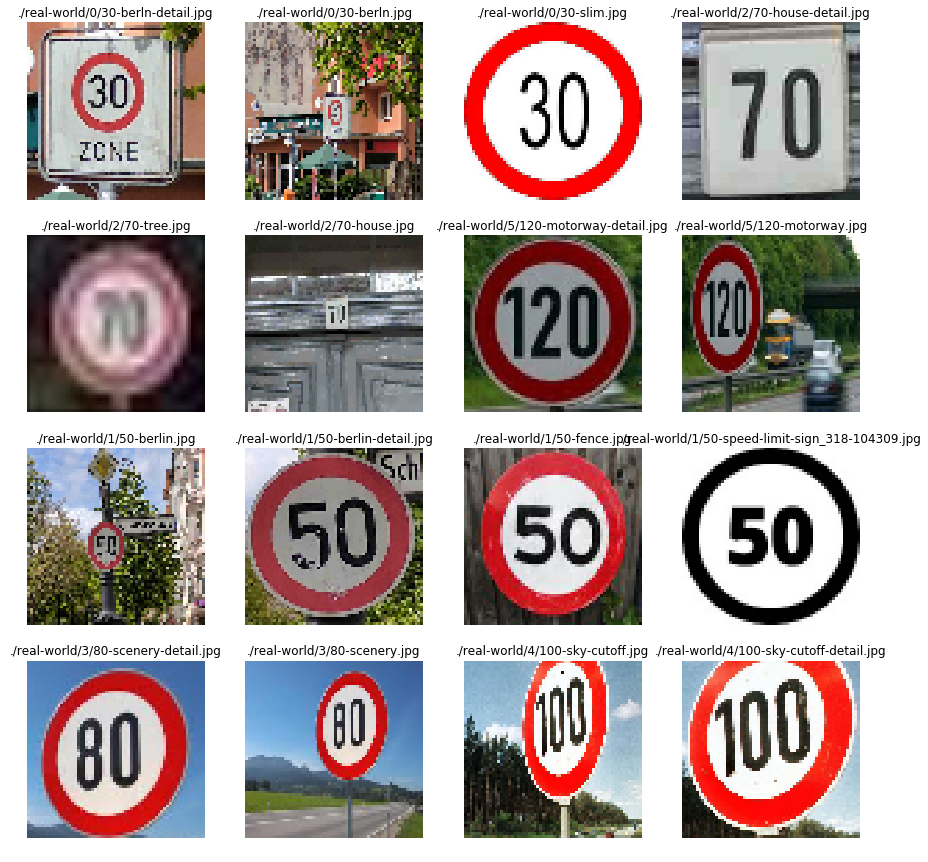

In [92]:
display_images_and_labels(images, file_names)

## Comparison

In [18]:
# # VGG
# !curl -O https://transfer.sh/15D4y3/conv-vgg.hdf5
# !curl -O https://transfer.sh/DuZA7/conv-simple.hdf5
# !curl -O https://transfer.sh/Co2au/conv-vgg-augmented.hdf5

# # Standard Architectures
# !curl -O https://transfer.sh/13vQp1/xception-augmented.hdf5
# !curl -O https://transfer.sh/15MGV8/resnet-augmented.hdf5

# # Retrained
# !curl -O https://transfer.sh/592Qh/vgg16-augmented-retrained.hdf5
# !curl -O https://transfer.sh/3a3gd/vgg16-augmented-retrained-fine-tuned.hdf5

In [19]:
!ls -lh *.hdf5

-rw-rw-r-- 1 ubuntu ubuntu 3.1M Oct  2 13:07 conv-minimal.hdf5
-rw-rw-r-- 1 ubuntu ubuntu  26M Oct  2 13:36 conv-simple.hdf5
-rw-rw-r-- 1 ubuntu ubuntu  55M Oct  1 15:13 conv-vgg-augmented.hdf5
-rw-rw-r-- 1 ubuntu ubuntu  55M Oct  1 14:54 conv-vgg.hdf5
-rw-rw-r-- 1 ubuntu ubuntu 6.3M Oct  1 14:34 conv-vgg-simple.hdf5
-rw-rw-r-- 1 ubuntu ubuntu 271M Oct  2 09:22 resnet-augmented.hdf5
-rw-rw-r-- 1 ubuntu ubuntu  88M Oct  1 10:22 vgg16-augmented-retrained-fine-tuned.hdf5
-rw-rw-r-- 1 ubuntu ubuntu  59M Oct  1 10:00 vgg16-augmented-retrained.hdf5
-rw-rw-r-- 1 ubuntu ubuntu  88M Oct  1 09:56 vgg16-retrained-fine-tuned.hdf5
-rw-rw-r-- 1 ubuntu ubuntu  59M Oct  1 09:26 vgg16-retrained.hdf5
-rw-rw-r-- 1 ubuntu ubuntu 239M Oct  1 14:32 xception-augmented.hdf5


In [20]:
from keras.models import load_model
from keras import backend as K

In [93]:
BATCH_SIZE = 500

y = np.array(labels)
X = np.array(images)
from keras.utils.np_utils import to_categorical

num_categories = 6

y = to_categorical(y, num_categories)

In [94]:
import skimage.transform
def predict_single(image):
    # normalize
    X_sample = np.array([image])
    prediction = model.predict(X_sample)
    predicted_category = np.argmax(prediction, axis=1)
    return predicted_category, prediction

In [95]:
# Display the predictions and the ground truth visually.
def display_prediction (images, true_labels, predicted_labels):
    fig = plt.figure(figsize=(10, 10))
    for i in range(len(true_labels)):
        truth = true_labels[i]
        prediction = predicted_labels[i]
        plt.subplot(6, 3,1+i)
        plt.axis('off')
        color='green' if truth == prediction else 'red'
        plt.text(80, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
                 fontsize=12, color=color)
        plt.imshow(images[i])

---

# Candidate 1: Our Custom VGG style model

---

## Variation 1: Trained on-non augmented data set

Just a few minutes on a K80

In [24]:
K.clear_session()
model = load_model('conv-vgg.hdf5')

In [25]:
loss, accuracy = model.evaluate(X, y, batch_size=BATCH_SIZE)
loss, accuracy

16/16 [==============================] - 0s


(5.1947088241577148, 0.625)

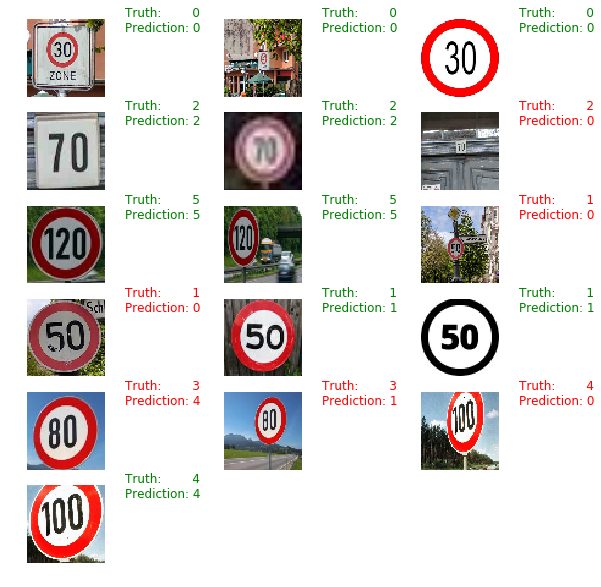

In [26]:
X_sample = np.array(images)
prediction = model.predict(X_sample)
predicted_categories = np.argmax(prediction, axis=1)
ground_truth = np.array(labels)
display_prediction(images, ground_truth, predicted_categories)

# Verdict: 10 out of 15, 60% Accuracy

## Not so bad

### But
* no translation invariance, signs have to be centered and zoomed in
* not robust against background
* false positives (70 is address sign, not traffic sign)
* not robust against unclear signes (50 looks like 30)
* not robust against distortions (100, 80)
* 64x64 resolution does not allow for anything but close-ups

### Next steps might be to
* artifically expand training set by applying transformations that match missing robustness
* introduce category 'no speed limit sign'
* translation invariance added in training material
* try other architectures

---

## Variation 2: Trained on the augmented data set


In [27]:
K.clear_session()
model = load_model('conv-vgg-augmented.hdf5')

In [28]:
loss, accuracy = model.evaluate(X, y, batch_size=BATCH_SIZE)
loss, accuracy

16/16 [==============================] - 0s


(6.5481042861938477, 0.3125)

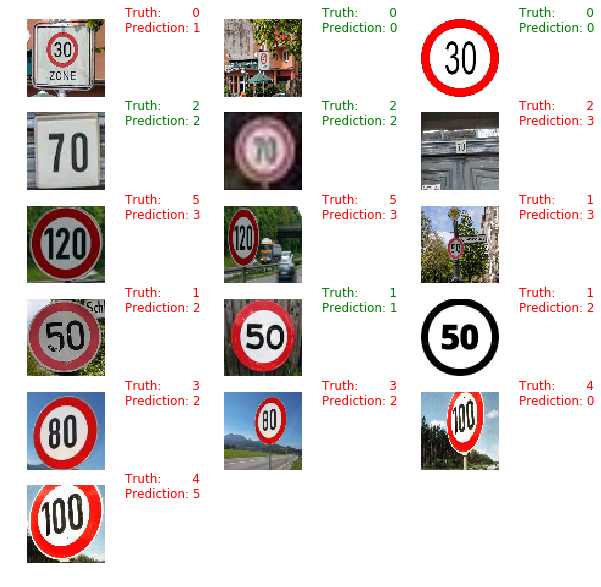

In [29]:
X_sample = np.array(images)
prediction = model.predict(X_sample)
predicted_categories = np.argmax(prediction, axis=1)
ground_truth = np.array(labels)
display_prediction(images, ground_truth, predicted_categories)

# Verdict: 5 out of 16, 30% Accuracy

* 4.5h training time on K80, still not fully trained
* does not even recognize b/w 50
* generalisation to real world has not worked well
* seems to have overfitted on the augmented data

---
# Simplified VGG Model

In [30]:
K.clear_session()
model = load_model('conv-simple.hdf5')

In [31]:
loss, accuracy = model.evaluate(X, y, batch_size=BATCH_SIZE)
loss, accuracy

16/16 [==============================] - 0s


(5.410158634185791, 0.4375)

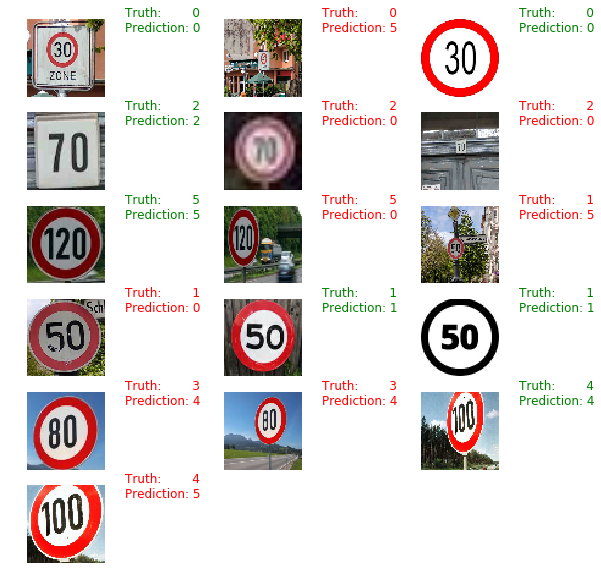

In [32]:
X_sample = np.array(images)
prediction = model.predict(X_sample)
predicted_categories = np.argmax(prediction, axis=1)
ground_truth = np.array(labels)
display_prediction(images, ground_truth, predicted_categories)

# 40% Not so bad, especially given it is really simple

---
# Xception (needs 299x299 input)

In [56]:
K.clear_session()
model = load_model('xception-augmented.hdf5')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, None, None, 32 864         input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, None, None, 32 128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, None, None, 32 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [77]:
loss, accuracy = model.evaluate(X, y)
loss, accuracy

16/16 [==============================] - 0s


(1.6016137599945068, 0.8125)

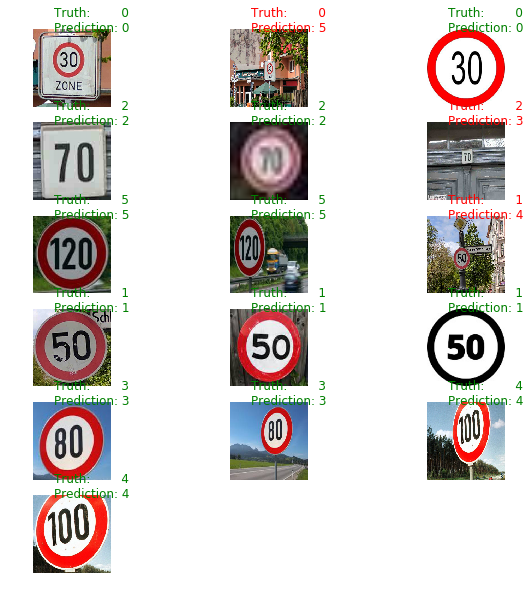

In [78]:
X_sample = np.array(images)
prediction = model.predict(X_sample)
predicted_categories = np.argmax(prediction, axis=1)
ground_truth = np.array(labels)
display_prediction(images, ground_truth, predicted_categories)

# 80% Outstanding results, just fails where sign is really zoomed out

---

# ResNet (needs 224x224 input)

In [86]:
K.clear_session()
model = load_model('resnet-augmented.hdf5')

In [87]:
loss, accuracy = model.evaluate(X, y, batch_size=BATCH_SIZE)
loss, accuracy

16/16 [==============================] - 1s


(2.4447090625762939, 0.5)

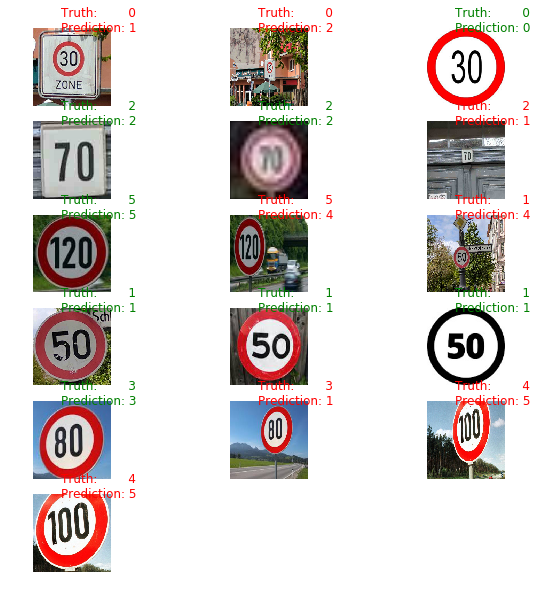

In [88]:
X_sample = np.array(images)
prediction = model.predict(X_sample)
predicted_categories = np.argmax(prediction, axis=1)
ground_truth = np.array(labels)
display_prediction(images, ground_truth, predicted_categories)

# 50%, neither good nor bad, might have trained it for a little bit longer

---

# VGG16 trained on ImageNet, retrained on augmented data

In [40]:
K.clear_session()
model = load_model('vgg16-augmented-retrained.hdf5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
model_1 (Model)              (None, 6)                 526086    
Total params: 15,240,774
Trainable params: 15,240,774
Non-trainable params: 0
_________________________________________________________________


In [41]:
loss, accuracy = model.evaluate(X, y, batch_size=BATCH_SIZE)
loss, accuracy

16/16 [==============================] - 0s


(6.4892158508300781, 0.25)

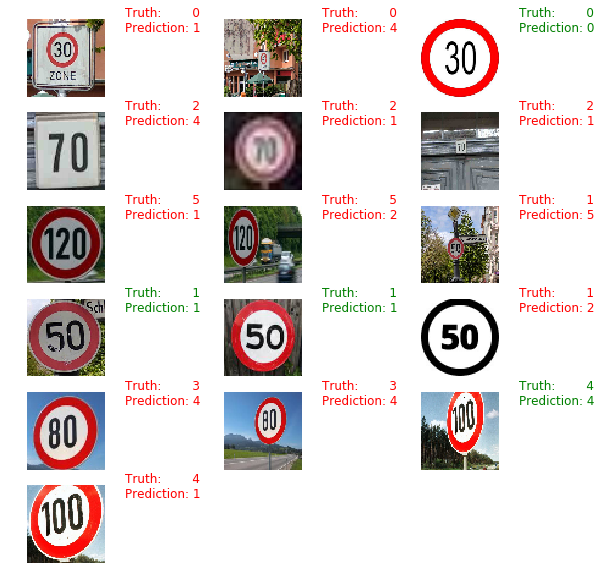

In [42]:
X_sample = np.array(images)
prediction = model.predict(X_sample)
predicted_categories = np.argmax(prediction, axis=1)
ground_truth = np.array(labels)
display_prediction(images, ground_truth, predicted_categories)

---

# VGG16 trained on ImageNet, retrained on augmented data and fine tuned

In [49]:
K.clear_session()
model = load_model('vgg16-augmented-retrained-fine-tuned.hdf5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
model_1 (Model)              (None, 6)                 526086    
Total params: 15,240,774
Trainable params: 7,605,510
Non-trainable params: 7,635,264
_________________________________________________________________


In [50]:
loss, accuracy = model.evaluate(X, y, batch_size=BATCH_SIZE)
loss, accuracy

16/16 [==============================] - 0s


(7.3838901519775391, 0.3125)

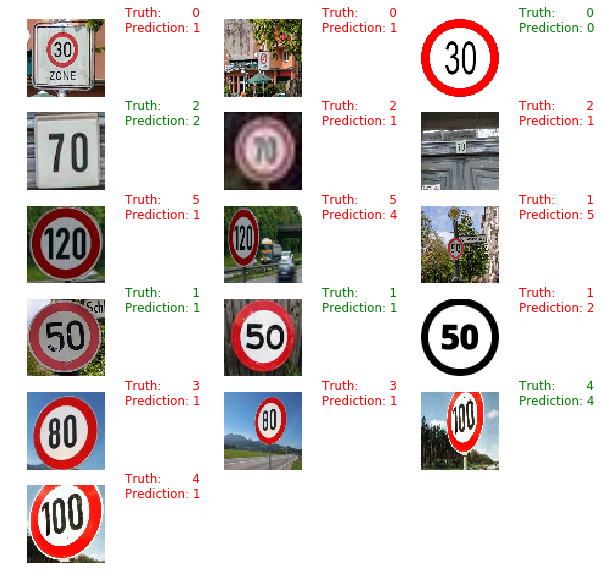

In [51]:
X_sample = np.array(images)
prediction = model.predict(X_sample)
predicted_categories = np.argmax(prediction, axis=1)
ground_truth = np.array(labels)
display_prediction(images, ground_truth, predicted_categories)

---

# VGG16 trained on ImageNet, retrained on original data

In [43]:
K.clear_session()
model = load_model('vgg16-retrained.hdf5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
model_6 (Model)              (None, 6)                 526086    
Total params: 15,240,774
Trainable params: 15,240,774
Non-trainable params: 0
_________________________________________________________________


In [44]:
loss, accuracy = model.evaluate(X, y, batch_size=BATCH_SIZE)
loss, accuracy

16/16 [==============================] - 0s


(6.9155426025390625, 0.25)

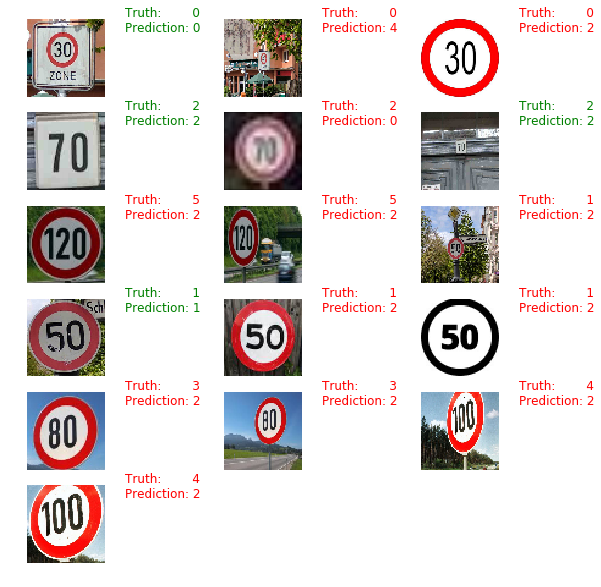

In [45]:
X_sample = np.array(images)
prediction = model.predict(X_sample)
predicted_categories = np.argmax(prediction, axis=1)
ground_truth = np.array(labels)
display_prediction(images, ground_truth, predicted_categories)

---

# VGG16 trained on ImageNet, retrained on original data and fine tuned

In [46]:
K.clear_session()
model = load_model('vgg16-retrained-fine-tuned.hdf5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
model_6 (Model)              (None, 6)                 526086    
Total params: 15,240,774
Trainable params: 7,605,510
Non-trainable params: 7,635,264
_________________________________________________________________


In [47]:
loss, accuracy = model.evaluate(X, y, batch_size=BATCH_SIZE)
loss, accuracy

16/16 [==============================] - 0s


(7.5806293487548828, 0.3125)

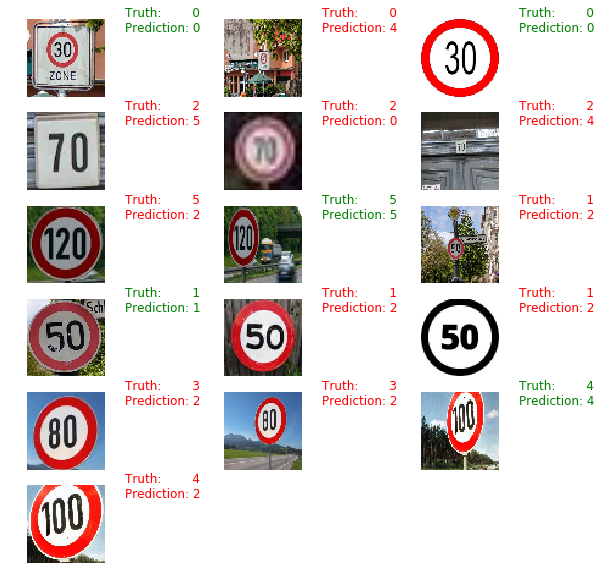

In [48]:
X_sample = np.array(images)
prediction = model.predict(X_sample)
predicted_categories = np.argmax(prediction, axis=1)
ground_truth = np.array(labels)
display_prediction(images, ground_truth, predicted_categories)

# Looks like pre-trained imagenet indeed does not help much in our domain

---

# Hands-On
## Add your own model: how does your model compare to the others in this free style competition?
* make sure you have saved it from previous notebooks
* copy the three cells from above needed to run the prediction and display the results

---